# Classifiez automatiquement des biens de consommation

## Résumé du projet
"Place de marché”, qui souhaite lancer une marketplace e-commerce. Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description

L'objectif principal de ce projet est d'etudier la faisabilité d'un moteur de classification des articles en différentes catégories des dponnees de l'entreprise Place de marché.

Cela permetra de  rendre l’expérience utilisateur des vendeurs et des acheteurs  la plus fluide possible. En plus, dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche 


## Librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import seaborn as sns
import os
import shutil
import re
import random as rn
import cv2
import time
import string
import sklearn.metrics as metrics
import tensorflow as tf

from zipfile import ZipFile
from os import listdir
from pathlib import Path
from functools import reduce
from tqdm import tqdm
from random import shuffle  
from PIL import Image
from numpy import genfromtxt
from wordcloud import WordCloud, STOPWORDS

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import intercluster_distance

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
from sklearn import cluster
from sklearn.manifold import TSNE
from sklearn import decomposition, preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold, GridSearchCV

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception

from tensorflow.keras.optimizers import Adam, SGD , Adagrad,Adadelta,RMSprop# - Works
from tensorflow.keras.utils import to_categorical

pd.set_option("display.precision", 2)          
pd.set_option("display.max.columns", None)    
pd.set_option("display.max.rows", None)

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
rstate=10
var_explained=0.75
seed = 10

## Données

In [3]:
dir_data = Path('../../DATA/P6') 
dir_fig  = Path('../../FIGURE/P6')
work_dir=os.getcwd()
CHECK_FOLDER  = Path('../../DATA/P6/Flipkart') 
CHECK_FOLDER_CNN = Path('../../DATA/P6/DATA_KAGGLE/Flipkart') 
img_path = Path(str(CHECK_FOLDER) + str('/Images/'))
desc_data=str(dir_data)+'/df_clean.csv'

### Traitement d'image

In [4]:
name_img =[]

# Boucle sur les images
for image in listdir(img_path):
    name_img.append(image)

data = pd.DataFrame()
data["image"] = name_img
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["image"])

df =pd.read_csv(desc_data)
data_merged = pd.merge(
    data, df, left_on='image', right_on='image')



In [5]:
orb_description = []
sift_description = []
imgs=[]
imgs = []
labels = []
categ=[]
IMAGE_SIZE=(224,224)

# Initiate SIFT / ORB detector
sift= cv2.SIFT_create()
orb = cv2.ORB_create()

# Boucle sur les images
for image in data_merged['image']:
    # Chargement des images 
    img = cv2.imread(str(img_path)+'/'+image)

    # Convering to Gray
    img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # convert all picture to the same size
    img = cv2.resize(img, IMAGE_SIZE) 

    # Amélioration contraste
    img = cv2.equalizeHist(img) 

    # Débruitage
    img = cv2.fastNlMeansDenoising(img)

    # filtre gausien
    img = cv2.GaussianBlur(img, (5, 5), 1)

    # find the keypoints and descriptors with ORB
    Keypoint_orb , Descripteur_orb = orb.detectAndCompute(img,None)
    orb_description.append(Descripteur_orb)
        
    Keypoint_sift , Descripteur_sift = sift.detectAndCompute(img,None)
    sift_description.append(Descripteur_sift)
        
    indx=data_merged[(data_merged['image'] == image)].index.values
    lab = data_merged['lab_category'][indx]
    Cat = data_merged['Category_0'][indx]
                
    # Append the image 
    imgs.append(img)
    labels.append(lab)
    categ.append(Cat)

imgs = np.array(imgs, dtype = 'float32') 
labels = np.array(labels, dtype = 'int32') 
categ  = np.array(categ)
    
orb_description_by_img = np.asarray(orb_description)
orb_description_all        = np.concatenate(orb_description_by_img, axis=0)
orb_description_pd     = pd.DataFrame(orb_description_all)
      
sift_description_by_img = np.asarray(sift_description)
sift_description_all    = np.concatenate(sift_description_by_img, axis=0)
sift_description_pd     = pd.DataFrame(sift_description_all)
    

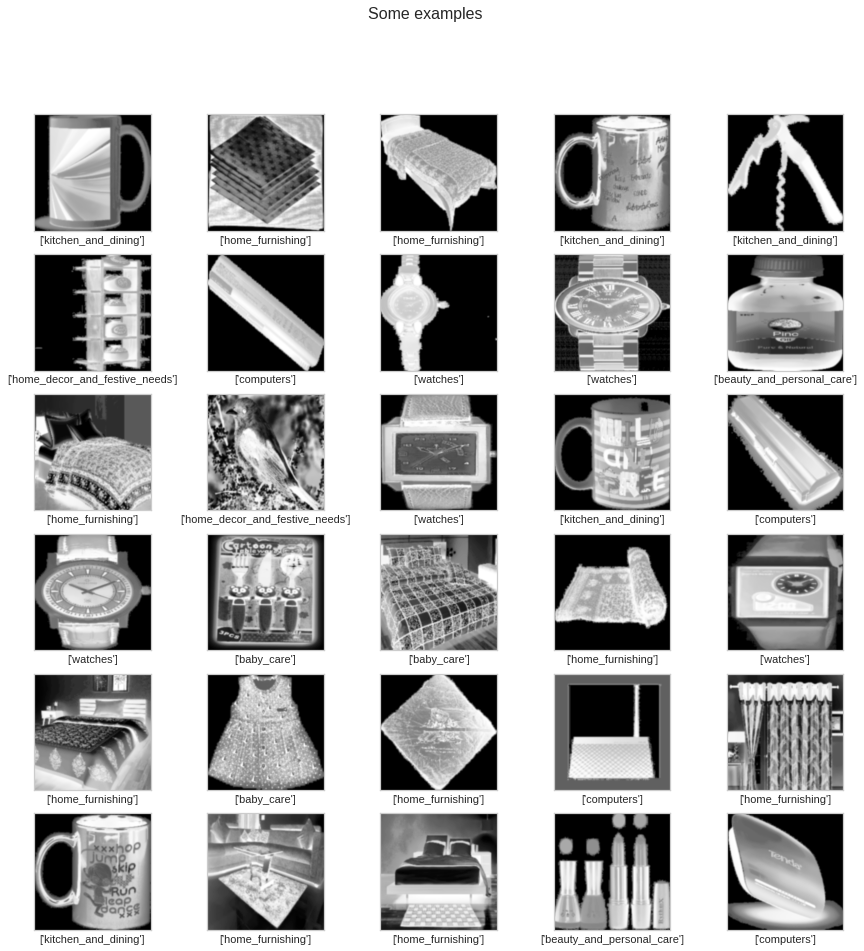

In [6]:
def display_examples(images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Some examples", fontsize=16)
    for i in range(30):
        plt.subplot(6,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()


display_examples(imgs, categ)

## Modélisation

### Classification non supervisée 

In [7]:
Idetector= {
     'orb':  'kmeans_orb',
     "sift": 'kmeans_sift'
    } 
Duration_detector={
     'orb':  'duration_orb',
     "sift": 'duration_sift'
    } 

Data_detector={
     'orb':  orb_description_all,
     "sift": sift_description_all
    }
for k in  Idetector:
    print(k)
    nclusters = int(round(np.sqrt(len(Data_detector[k])),0))
    temps1=time.time()
    # Clustering
    Idetector[k] = cluster.MiniBatchKMeans(nclusters, init_size=3*nclusters, random_state=rstate)
    Idetector[k].fit(Data_detector[k])
    Duration_detector[k]=time.time()-temps1

    print('Duration',k,':',Duration_detector[k])

orb
Duration orb : 20.27527379989624
sift
Duration sift : 4.8744165897369385


#### Création des features des images

In [8]:
# Creation of histograms (features)

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

# Creation of a matrix of histograms
def hist_build(description_all,model):
    hist_vectors=[]
    for i, image_desc in enumerate(description_all) :
        if i%100 == 0 : print(i)  
        hist = build_histogram(model, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector

    im_features = np.asarray(hist_vectors)
    
    return im_features

In [9]:
Data_detector_img={
     'orb':  orb_description_by_img,
     "sift": sift_description_by_img
    }
im_feature_keap={'orb': 'im_feature_orb',
            "sift": 'im_feature_sift'}

min_duration=min(Duration_detector)  # prend le modele le plus rapide

for k in  Idetector:
    if k==min_duration:
        data_kept=Data_detector_img[k]
        model_kept=Idetector[k]
        im_feature=im_feature_keap[k]
        print('model kept is:',k)
        
temps1=time.time()
im_features=hist_build(data_kept,model_kept)
duration1=time.time()-temps1

print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


model kept is: orb
0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.10 secondes


#### Réductions de dimension

##### Réduction de dimension PCA

In [10]:
var_explained=0.75

def pca_red_dim(model_res,var_explained):
    pca = PCA(var_explained)  
    df_PCA = pca.fit_transform(model_res)
    num_pc = len(pca.components_) 
    pc_list = [str(i) for i in list(range(1, num_pc+1))] #["PC"+str(i) for i in list(range(1, num_pc+1))]
    X_pca   = pca.transform(model_res)
    return pc_list,pca,X_pca

def fig_pca(X_PCA,ax):
    chaine = "Plan factoriel pour les composantes 1 et 2 de l'ACP"
    ax.set_title(chaine)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    sns.scatterplot(
        x=X_PCA[:,0],
        y=X_PCA[:,1],
        hue=df['Category_0'],ax=ax,
        alpha=0.8,
        s=30
    )

[pc,pca,X_pca] = pca_red_dim(im_features,var_explained)

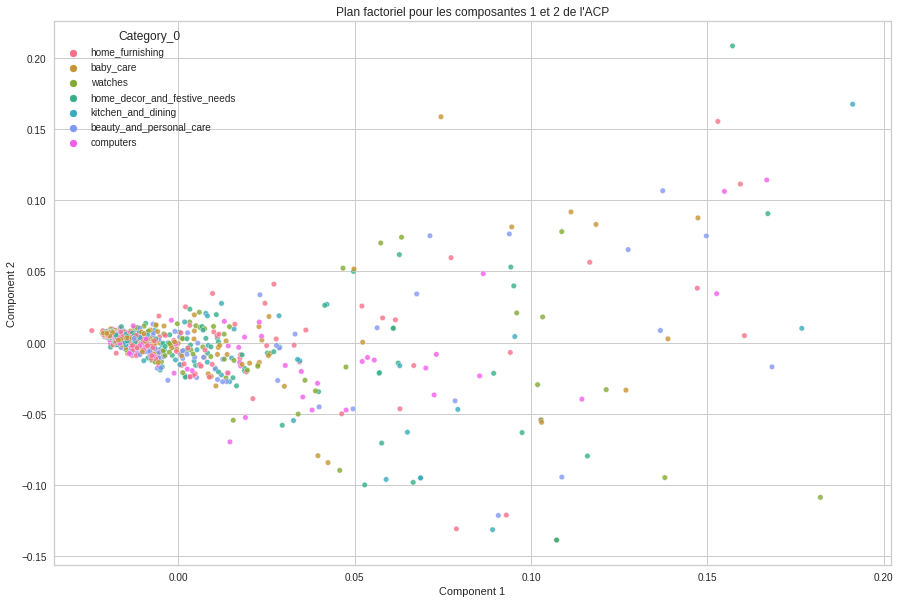

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
fig_pca(X_pca,ax)

In [12]:
tsne = TSNE(n_components=2, init="pca")
X_tsne  = tsne.fit_transform(X_pca)
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['Category_0']

In [13]:
def plot_tsne(df,ax,classe):
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=classe, data=df, ax=ax,legend="brief",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

    ax.set_title('TSNE selon les vraies classes', fontweight = 'bold')
    ax.set_xlabel('tsne1')
    ax.set_ylabel('tsne2')

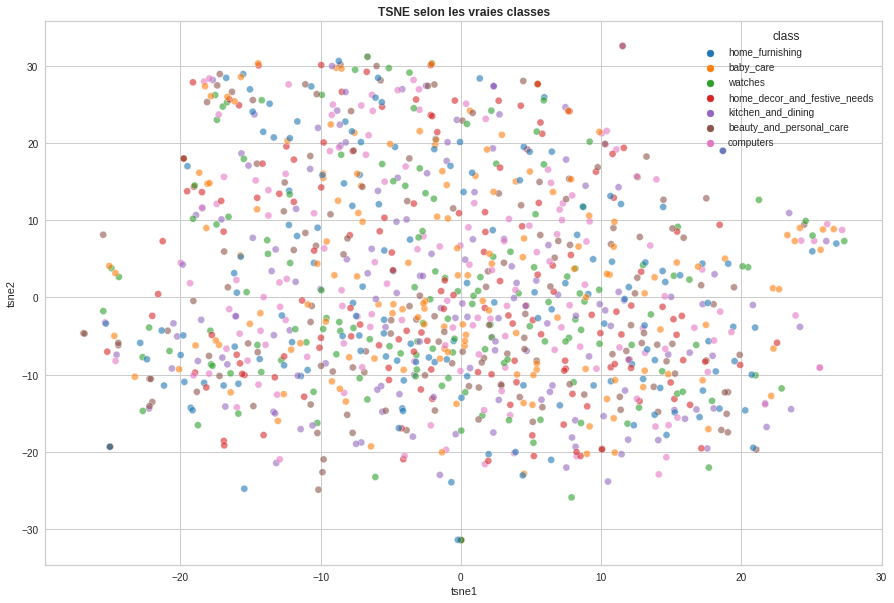

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
plot_tsne(df_tsne,ax,"class")

In [15]:
def fit_KMeans_model(df_X,nclusters,nstate):
    kmeans_visualizer = KMeans(n_clusters=nclusters,random_state=nstate)
    kmeans_visualizer.fit(df_X)
    name='Cluster = '+str(nclusters)
    label = kmeans_visualizer.labels_
    return label,name

In [16]:
[labels,name] = fit_KMeans_model(X_tsne,7,rstate)

df_tsne[name]=labels

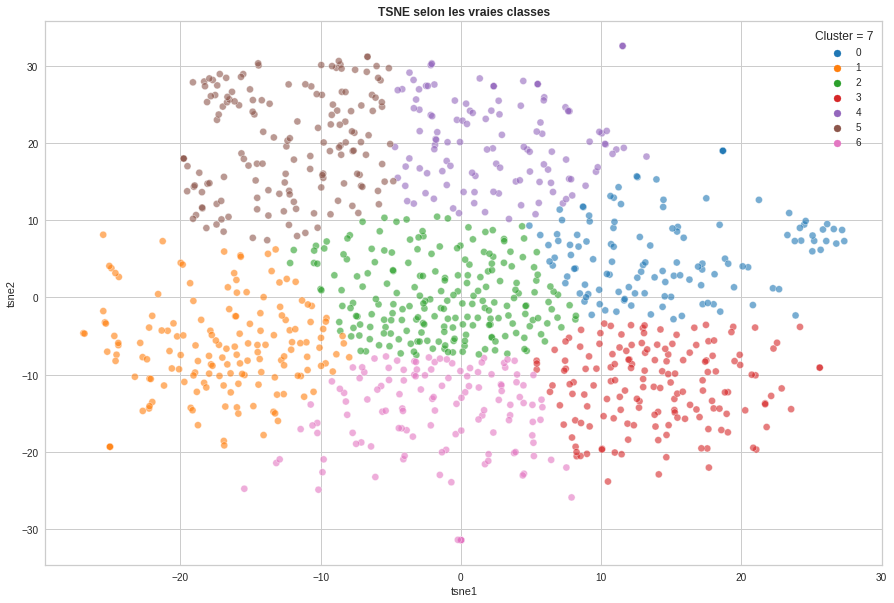

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
plot_tsne(df_tsne,ax,name)

In [18]:

ARI_CAT_KMeans=adjusted_rand_score(data_merged['lab_category'],df_tsne[name])

accuracy = accuracy_score( data_merged['lab_category'],df_tsne[name])
precision= precision_score(data_merged['lab_category'],df_tsne[name], average='weighted')

algo_Performance={"Algorithme": "Kmeans",'accuracy':accuracy ,\
                  'precision':precision}
PerformanceK = pd.DataFrame( algo_Performance,
        index=[0],
    )

PerformanceK

,Algorithme,accuracy,precision
0,Kmeans,0.14,0.13


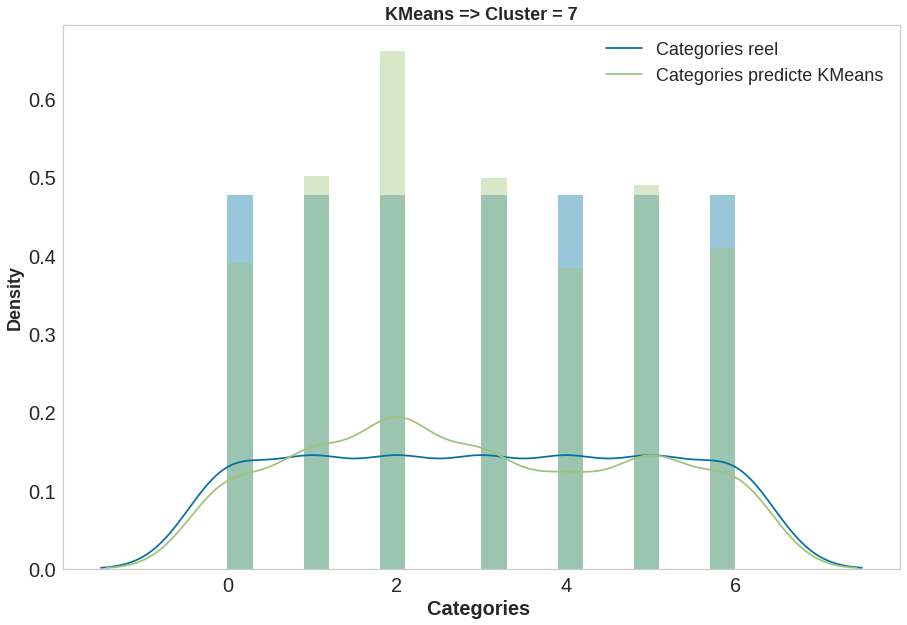

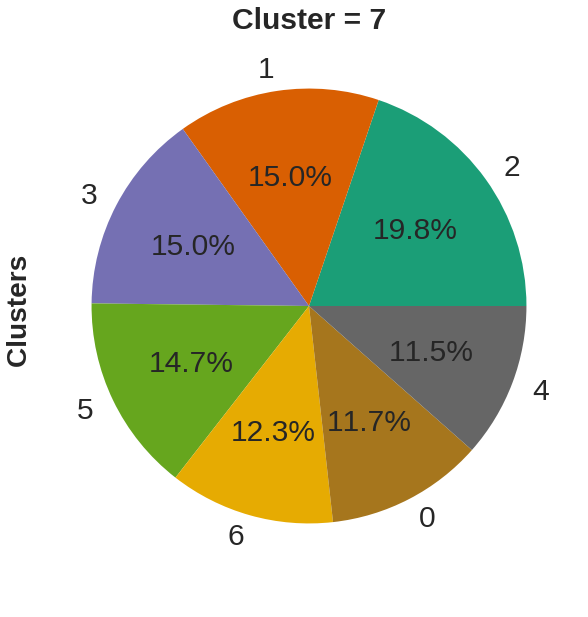

In [19]:
dss=20
tnx=0
names=["Density_kmeans_image.jpeg", "KMeans_pie_image.jpeg"]
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(df['lab_category'], bins=20, rug=False,ax=ax)
ax.set_title('KMeans => '+ name, weight='bold', size=dss-2)
sns.distplot(df_tsne[name], bins=20, rug=False,ax=ax)
ax.set_xlabel("Catégories")
ax.legend(['Categories reel', 'Categories predicte KMeans'], fontsize=dss-2)

ax.set_ylabel('Density', weight='bold', size=dss-2)
ax.set_xlabel('Categories ', weight='bold', size=dss)
plt.grid(False)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss) 
figure_name=names[tnx]
        
plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

tnx=tnx+1
dss=30
fig, ax2 = plt.subplots(figsize=(25,10))
data_plot_0 = df_tsne.groupby(name).agg(Clusters =('class','count'))

data_plot_0=data_plot_0.sort_values(by='Clusters', ascending=False)
data_plot_0.plot(kind='pie', x=name, y='Clusters', title = '', 
cmap='Dark2', autopct="%.1f%%", legend=False,ax=ax2,fontsize=dss).set_title(name,fontsize=dss, weight='bold');

ax2.set_ylabel('Clusters ', weight='bold', size=dss-2)
ax2.set_xlabel(' ', weight='bold', size=dss)
plt.grid(False)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss) 
figure_name=names[tnx]

        
plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp "KMeans_pie_image.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "KMeans_pie_image.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6
!mv "Density_kmeans_image.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6


In [20]:
cmf = confusion_matrix(data_merged['lab_category'], df_tsne[name])

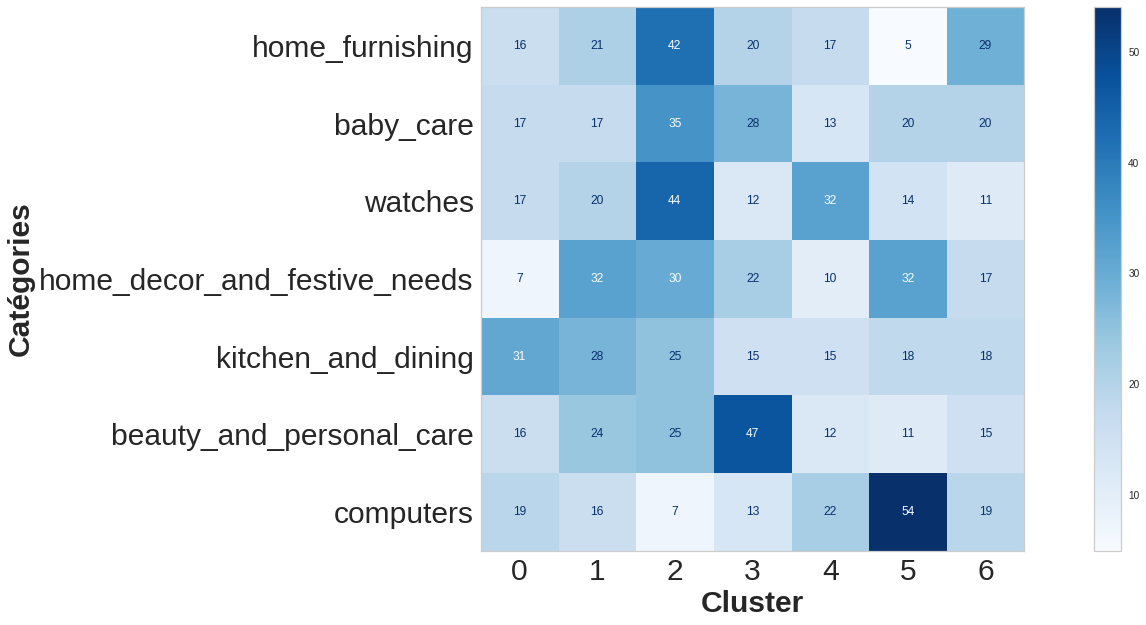

In [21]:
f, (ax1) = plt.subplots(1,1, figsize=(25,10))
cm_display = ConfusionMatrixDisplay(cmf).plot(ax=ax1,cmap=plt.cm.Blues)
plt.rcParams.update({'font.size': dss})
ax1.set_ylabel("Catégories", weight='bold', size=dss)
ax1.set_xlabel('Cluster', weight='bold', size=dss)
ax1.set_yticklabels(df_tsne['class'].unique(), size=dss)
plt.xticks(fontsize=dss)
plt.grid(False)

### Classification supervisée 

In [22]:
Y=data_merged['lab_category']
Cat=df_tsne['class']
X=df_tsne.drop(['class',name],axis=1)

In [23]:
supervise=1
if supervise==1:
    params_Classifiers = {
     "RandomForestClassifier":     {'bootstrap': [True, False],'max_depth': [5,10,20],'max_features': [2, 4],'min_samples_leaf': [2, 4]},  
     'KNeighborsClassifier':       {'n_neighbors': [2,5],'weights': ['uniform','distance']}
    }
    
    Classifiers = {
     "RandomForestClassifier": RandomForestClassifier(random_state=seed),
     'KNeighborsClassifier':  KNeighborsClassifier()
    }   
def Multi_output_improved_Classifier_model(Classifiers,params_regressors,X_train, y_train,Cat,n_splits,seed):
    
    results= pd.DataFrame(index=["RMSE",\
                                "best_estimator_","best_params_",'accuracy_score','precision_score']) 
    
    Findex=['Cible predite']    
    frames_train= [] 
    column_Classifier=[]
   
    for ks in Classifiers:
        column_Classifier.append(ks)
#-------------------------------------------------------------------------------------------------------------

    for model_idx in Classifiers:       
        #
        print(model_idx)
        Classifier  = Classifiers[model_idx]
        param_grid= params_Classifiers[model_idx]
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        
        grid_search = GridSearchCV(estimator=Classifier, param_grid=param_grid, cv=kfold)
        
        grid_search.fit(X_train,  y_train)
        
        y_train_pred= grid_search.best_estimator_.predict(X_train)
        train_pred=pd.DataFrame(y_train_pred,index=y_train.index,columns=Findex)
       
        train_rmse=np.sqrt(mean_squared_error(y_train,train_pred)) 
     
        accu=accuracy_score(y_train, y_train_pred)
        prec=precision_score(y_train, y_train_pred, average='weighted')
        
        results[model_idx]=[train_rmse,grid_search.best_estimator_,grid_search.best_params_, accu,prec]
    
        Y_pred_train= pd.concat([y_train,train_pred,Cat],axis=1)
        frames_train.append(Y_pred_train)

    df_pred_train = pd.concat(frames_train, keys=column_Classifier, axis=1)
    
    results=results.T
    
    results=results.sort_values(by=["RMSE"],axis=0, ascending=True)
    return results,df_pred_train

nsplits=10
[eval_results_improved,pred_train_improved]=Multi_output_improved_Classifier_model\
             (Classifiers,params_Classifiers,X,Y,Cat,nsplits,seed)

RandomForestClassifier
KNeighborsClassifier


In [24]:
eval_results_improved.style.background_gradient(axis=None,cmap="coolwarm", subset=['RMSE'])

,RMSE,best_estimator_,best_params_,accuracy_score,precision_score
KNeighborsClassifier,0.00,KNeighborsClassifier(weights='distance'),"{'n_neighbors': 5, 'weights': 'distance'}",1.00,1.00
RandomForestClassifier,1.68,"RandomForestClassifier(max_depth=10, max_features=2, min_samples_leaf=2, random_state=10)","{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 2}",0.69,0.70


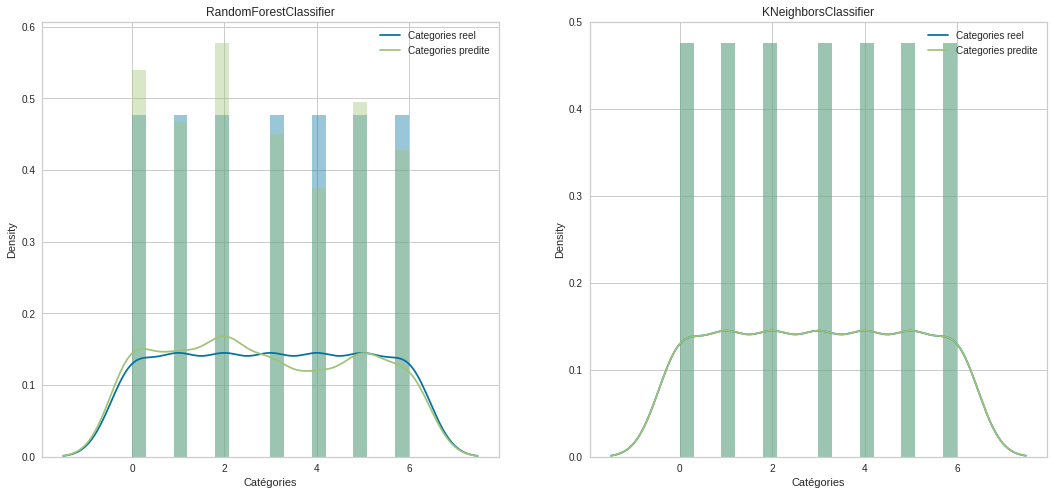

In [25]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(18,8))
axes=[ax1,ax2]
tnx=0
for knx in Classifiers:
    ax=axes[tnx]
    tnx=tnx+1
    x_cv_data=pred_train_improved[knx]
    sns.distplot(x_cv_data['lab_category'], bins=20, rug=False,ax=ax).set(title=knx)
    sns.distplot(x_cv_data['Cible predite'], bins=20, rug=False,ax=ax)
    ax.set_xlabel("Catégories")
    ax.legend(['Categories reel', 'Categories predite'])

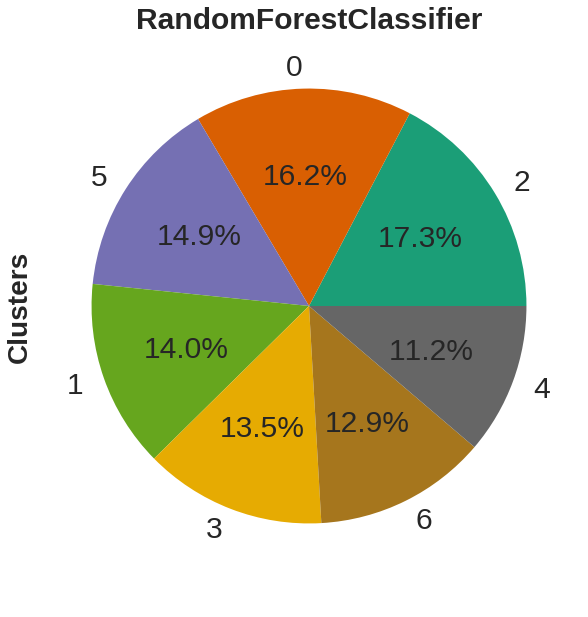

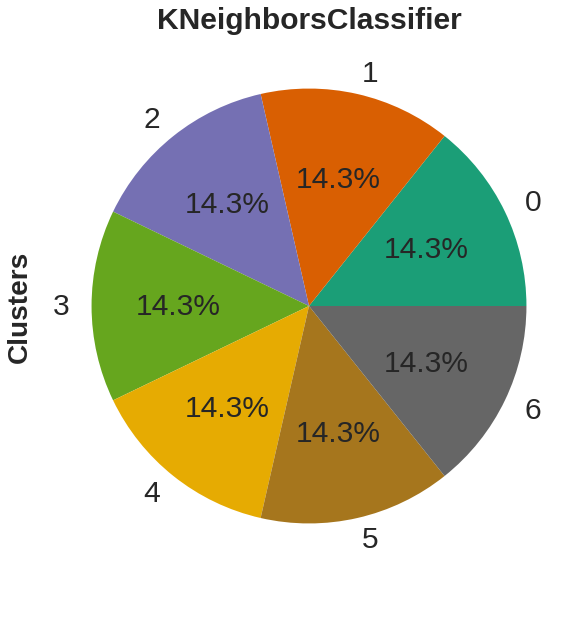

In [26]:
tnx=0
names=["RandomForestClassifier_pie_image.jpeg", "KNeighborsClassifier_pie_image.jpeg"]
dss=30
for knx in Classifiers:
        fig, ax2 = plt.subplots(figsize=(25,10))
        x_cv_data=pred_train_improved[knx]
        data_plot_0 = x_cv_data.groupby('Cible predite').agg(Categories =('class','count'))
        data_plot_0 =data_plot_0.sort_values(by='Categories', ascending=False)
        data_plot_0.plot(kind='pie', x='Cible predite', y='Categories', 
        cmap='Dark2', autopct="%.1f%%", legend=False,ax=ax2,fontsize=dss).set_title(knx,fontsize=dss, weight='bold');
        
        ax2.set_ylabel('Clusters', weight='bold', size=dss-2)
        ax2.set_xlabel('   ', weight='bold', size=dss)
        plt.xticks(fontsize=dss)
        plt.grid(False)
        plt.xticks(fontsize=dss) 
        figure_name=names[tnx]
        
        plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')
        tnx=tnx+1
        
!cp "RandomForestClassifier_pie_image.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "RandomForestClassifier_pie_image.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6
!cp "KNeighborsClassifier_pie_image.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "KNeighborsClassifier_pie_image.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6


In [28]:
tnx=0
for knx in Classifiers:
    x_cv_data = pred_train_improved[knx]

    accuracy = accuracy_score( data_merged['lab_category'],x_cv_data['Cible predite'])
    precision= precision_score(data_merged['lab_category'],x_cv_data['Cible predite'], average='weighted')
    
    algo_Performance={"Algorithme": knx, 'accuracy':accuracy ,'precision':precision}
    
    Performance = pd.DataFrame( algo_Performance,index=[tnx])

    if tnx==0:
        df1=PerformanceK.append(Performance, ignore_index=True)
    elif tnx==1:
        df_ARI=df1.append(Performance, ignore_index=True)
        
    tnx=tnx+1

df_ARI

,Algorithme,accuracy,precision
0,Kmeans,0.14,0.13
1,RandomForestClassifier,0.69,0.70
2,KNeighborsClassifier,1.00,1.00


In [33]:
for knx in Classifiers:
    if knx=='RandomForestClassifier':
        Best_IMG=pd.DataFrame(pred_train_improved[knx])

In [40]:
Best_IMG['uniq_id']=data_merged['uniq_id']
file=str(dir_data) + '/Best_IMG.csv'
Best_IMG.to_csv(file)